# **YELP DATA ANALYSIS**

# **Introduction**
Yelp is a social networking site which lets its users post reviews and rate different businesses and it  shares information about them. Users are allowed to write reviews or give tips to the businesses. Reviews are generally long and very detailed, whereas, tips are just short sentences describing the experience of the users. According to the research done by Harvard Business School, a one-star increase in Yelp rating leads to a 5-9 percent increase in revenue. This effect is driven by independent restaurants as ratings do not affect restaurants with chain affiliation. [1] Yelp helps businesses in improving their services and also provides users with an opportunity to select the best business.

### **Objective**
This project has been divided into 4 parts:
1. **Exploration of Yelp data through Pyspak queries**: Spark SQL module is used to explore the yelp data. This section is subdivided into two parts - the first part consists of general analysis of yelp dataset and the second part is specific to the analysis of all restaurants mentioned in the yelp dataset.  
1. **Sentiment Analysis**: In this section, sentiment analysis is performed on the reviews given by users to restaurants. Support Vector Machine and Logistic Regression are the two machine learning models which are used to classify the reviews as positive or negative, and their performances is compared. Here, both the models have performed equally well, giving a good accuracy of 89.91% and 89.88% respectively.

1. **Performance of different number of worker nodes**: Time taken by local device, 2 worker nodes, 3 worker nodes and 5 worker nodes to perform sentiment analysis is noted and  compared. In this section, it is observed that as the number of worker nodes increases, the time taken to execute the code decreases. Thus, 5 worker nodes take the least amount of time to execute the code.

1. **Latent Dirichlet Allocation (LDA)**: LDA is used on the tip dataset to identify the topic distribution of tips for good and poor restaurants, where good restaurants are the ones with more than 3 stars and poor restaurants are the ones with less than 3 stars.

### **Why is this project of interest?**
1. This project involves the use of technologies like Dataproc cluster on GCP, which make the task of working with big data using querying and machine learning methods easier, while also reduce the computation time needed to perform the same tasks.
1. Spark is also becoming the new norm for Big Data analytic, and so this is a dive into one of the more popular technologies to perform such analysis.   
1. This project also gives me opportunity to analyse Yelp data and extract useful information from it. In the age of Big Data and Social Computing, reviews and ratings given by customers are quite essential in forecasting the success of businesses. 


### **Importing Libraries**

In [0]:
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
from pyspark.sql.functions import *
from pyspark.sql.types import * 
from datetime import date, timedelta, datetime
from pyspark.sql import functions as f
from pyspark.sql.functions import split,explode
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import NGram, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import LogisticRegression
import re
import string
import nltk 
nltk.download('all') 
sc.defaultParallelism

# **Data Description**
The Yelp dataset has been downloaded from the Yelp official website. The size of the dataset is 10.46GB. It contains 4 json files - business dataset, review dataset, user dataset, tip dataset and checkin dataset. In total, there is information on 209,393 unique business ids and 1,968,703 unique user ids. In this project I have mainly used business data, review data, user data and tip data.

Attributes of business dataset:
1. business_id: 22 character unique business id
1. name: name of the business
1. address: address of the business
1. city: city of the business
1. state: 2 character state code, if applicable
1. postal_code: postal code of the business
1. latitude: latitude of the business
1. longitude: longitude of the business
1. stars: average rating of the business
1. review_count: number of reviews 
1. is_open: 1 if the business is open, else 0
1. categories: an array of strings of business categories
1. attributes: business attributes
1. hours: an object of key day to value hours

Attributes of review dataset:
1. business_id: unique business id of the business
1. cool: number of cool votes
1. funny: number of funny votes
1. useful: number of useful votes
1. date: the day review was written
1. review_id: 22 character unique review id
1. stars: ratings given by the users
1. text: review written by the users
1. user_id: 22 character unique user id

Attributes of user dataset:
1. business_id: unique business id of the business
1. cool: number of cool votes sent by the user
1. funny: number of funny votes sent by the user
1. useful: number of useful votes sent by the user
1. date: the day review was written
1. review_id: 22 character unique review id
1. stars: ratings given by the users
1. text: review written by the users
1. user_id: 22 character unique user id
1. fans: number of fans a user has
1. elite: years when the user was an elite
1. average_stars: average rating of all the ratings given by the user

Attributes of tip dataset:
1. text: tip written by the users for the business
1. compliment_count: number of compliments it has
1. date: the day tip was written
1. business_id: unique business id of the business
1. user_id: 22 character unique user id





### **Loading Data**

In [0]:
business_data = 'hdfs:///yelp/yelp_academic_dataset_business.json'
review_data = "hdfs:///yelp/yelp_academic_dataset_review.json"
tip_data = "hdfs:///yelp/yelp_academic_dataset_tip.json"
user_data = "hdfs:///yelp/yelp_academic_dataset_user.json"
checkin_data = "hdfs:///yelp/yelp_academic_dataset_checkin.json"


In [0]:
# Reading the files
yelp_business = spark.read.json(business_data)
yelp_review = spark.read.json(review_data)
yelp_user = spark.read.json(user_data)
yelp_tip = spark.read.json(tip_data)
yelp_checkin = spark.read.json(checkin_data)

### **Printing Schema**

In [0]:
business_schema = yelp_business.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [0]:
review_schema = yelp_review.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [0]:
tip_schema = yelp_tip.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- compliment_count: long (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)
 |-- user_id: string (nullable = true)



In [0]:
user_schema = yelp_review.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [0]:
checkin_schema = yelp_checkin.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- date: string (nullable = true)



# **Part I : Query using Pyspark-SQL**

In this section Yelp Data has been explored using Spark SQL in two parts -

(a) General analysis of the data 

(b) Analysis on restaurants

## **A. General Analysis of Yelp Dataset**



### **1. Top 10 Businesses**

In [0]:
# Selecting the column categories
category = yelp_business.select('categories')

# Converting each row into an array of elements and returning a new row for each element in the array
unique_category = category.select(explode(split('categories', ', ')).alias('category'))

# Count of each category and sort it
merge_category = unique_category.groupby('category').count()
top_category = merge_category.sort('count',ascending=False)
top_category.show(10,truncate=False)

+----------------+-----+
|category        |count|
+----------------+-----+
|Restaurants     |63944|
|Shopping        |34644|
|Food            |32991|
|Home Services   |22487|
|Beauty & Spas   |20520|
|Health & Medical|19227|
|Local Services  |15783|
|Automotive      |14720|
|Nightlife       |14211|
|Bars            |12400|
+----------------+-----+
only showing top 10 rows



**Observation:**

* It can be seen from the above table that restaurants have the highest number of businesses in Yelp dataset. 

### **2. Top 10 Cities With Most Businesses**

In [0]:
city = yelp_business.select("city")
# count of cities 
city_count = city.groupby("city").count()
top_city = city_count.sort('count',ascending=False)
top_city.show(10)

+----------+-----+
|      city|count|
+----------+-----+
| Las Vegas|31631|
|   Toronto|20366|
|   Phoenix|20171|
| Charlotte|10422|
|Scottsdale| 9342|
|   Calgary| 8377|
|Pittsburgh| 7630|
|  Montréal| 6979|
|      Mesa| 6577|
| Henderson| 5272|
+----------+-----+
only showing top 10 rows



**Observation:**

* Las Vegas has maximum number of businesses, followed by Toronto and Phoenix.

### **3. Businesses With Highest Ratings**

In [0]:
# count of restaurants which have rating 5
rating = yelp_business.where(col("stars")==5).select('business_id','name','city','review_count','categories').distinct()
rating.sort("review_count",ascending = False).show(10,True)

+--------------------+--------------------+----------+------------+--------------------+
|         business_id|                name|      city|review_count|          categories|
+--------------------+--------------------+----------+------------+--------------------+
|Xg5qEQiB-7L6kGJ5F...|     Little Miss BBQ|   Phoenix|        2329|Barbeque, Restaur...|
|IhNASEZ3XnBHmuuVn...|        Brew Tea Bar| Las Vegas|        1827|Restaurants, Food...|
|9MVKjEMN5T59uzG1x...|     Cocina Madrigal|   Phoenix|        1107|Restaurants, Mexican|
|Kp4i7on7rxFRkWceK...|Paranormal - Mind...| Las Vegas|         979|Casinos, Magician...|
|16d3BlncEyCTzb0Gx...|Green Corner Rest...|      Mesa|         858|Restaurants, Hala...|
|tIX6o1jkLrrmsJIdG...|            Eco-Tint| Las Vegas|         853|Shopping, Home Se...|
|SSCH4Z2gw-hh2KZy7...|      Worth Takeaway|      Mesa|         842|Breakfast & Brunc...|
|8fFTJBh0RB2EKG53i...|      Zenaida's Cafe| Las Vegas|         717|Cafes, Breakfast ...|
|1qkKfqhO8z2XMzLLD...

## **B. Analysis on Restaurants**

In [0]:
# getting the data on all restaurants
yelp_restaurants = yelp_business.filter(yelp_business.categories.contains('Restaurants')).distinct()

### **1. Top 10 Cities With Most Restaurants**

In [0]:
city = yelp_restaurants.select("city")

# getting the count restaurants in each city
city_count = city.groupby("city").count()
top_city = city_count.sort('count',ascending=False)
top_city.show(10)

+-----------+-----+
|       city|count|
+-----------+-----+
|    Toronto| 8679|
|  Las Vegas| 6931|
|    Phoenix| 4217|
|   Montréal| 4097|
|    Calgary| 3117|
|  Charlotte| 2922|
| Pittsburgh| 2608|
| Scottsdale| 1652|
|Mississauga| 1612|
|  Cleveland| 1550|
+-----------+-----+
only showing top 10 rows



**Observation:**

* Toronto has maximum number of restaurants.

### **2. Top 10 Categories Of Restaurant**

In [0]:
category = yelp_restaurants.select('categories')

# Converting each row into an array of elements and returning a new row for each element in the array
individual_category = category.select(explode(split('categories', ', ')).alias('category'))

# Choosing different types of restaurants and rename the category
newDf = individual_category.withColumn('category', regexp_replace('category', 'Pizza', 'Italian'))
newDf = newDf.withColumn('category', regexp_replace('category', 'Tacos', 'Mexican'))
newDf = newDf.withColumn('category', regexp_replace('category', 'Sushi Bars', 'Japanese'))
newDf = newDf.withColumn('category', regexp_replace('category', 'Burgers', 'American'))
newDf = newDf.withColumn('category', regexp_replace('category', 'American \\(New\\)', 'American'))
newDf = newDf.withColumn('category', regexp_replace('category', 'American \\(Traditional\\)', 'American'))

# not including restaurants and food because I am interested in finding out what kind
#of restaurants or food are more popular
df_filtered=newDf.filter((newDf.category != 'Restaurants') & (newDf.category != 'Food'))
grouped_category = df_filtered.groupby('category').count()
top_category = grouped_category.sort('count',ascending=False)
top_category.show(10,truncate=False)

+------------------+-----+
|category          |count|
+------------------+-----+
|American          |18821|
|Italian           |12314|
|Nightlife         |9400 |
|Bars              |9004 |
|Fast Food         |8106 |
|Sandwiches        |8064 |
|Breakfast & Brunch|6225 |
|Mexican           |6069 |
|Japanese          |5432 |
|Chinese           |4746 |
+------------------+-----+
only showing top 10 rows



**Observation:**
* American and Italian cuisines are quite popular. 

### **3. Top Ratings Given By Users**

In [0]:
rating = yelp_restaurants.select('stars')

# counting the ratings 
group_rating = rating.groupby('stars').count()
rating_top = group_rating.sort('count',ascending=False)
rating_top.show(truncate=False)

+-----+-----+
|stars|count|
+-----+-----+
|4.0  |15495|
|3.5  |15066|
|3.0  |11388|
|4.5  |7985 |
|2.5  |6487 |
|2.0  |3848 |
|5.0  |1670 |
|1.5  |1545 |
|1.0  |460  |
+-----+-----+



**Observation**
* In general, users give higher ratings to restaurants, i.e ratings greater than or equal to 3.
* Very few restaurants have rating equal to 5.


### **4. Restaurants With Highest Ratings**

In [0]:
# finding restaurants with rating 5
rating = yelp_restaurants.where(col("stars")==5).select('business_id','name','city','review_count')
rating.sort("review_count",ascending = False).show(10,False)

+----------------------+-----------------------+----------+------------+
|business_id           |name                   |city      |review_count|
+----------------------+-----------------------+----------+------------+
|Xg5qEQiB-7L6kGJ5F4K3bQ|Little Miss BBQ        |Phoenix   |2329        |
|IhNASEZ3XnBHmuuVnWdIwA|Brew Tea Bar           |Las Vegas |1827        |
|9MVKjEMN5T59uzG1xoD2BQ|Cocina Madrigal        |Phoenix   |1107        |
|16d3BlncEyCTzb0GxXrBXQ|Green Corner Restaurant|Mesa      |858         |
|SSCH4Z2gw-hh2KZy7aH4qw|Worth Takeaway         |Mesa      |842         |
|8fFTJBh0RB2EKG53ibiBKw|Zenaida's Cafe         |Las Vegas |717         |
|1qkKfqhO8z2XMzLLDFE96Q|Kodo Sushi Sake        |Scottsdale|695         |
|G4hjhtA_wQ-tSOGpgGlDjw|Bajamar Seafood & Tacos|Las Vegas |658         |
|cePE3rCuUOVSCCAHSjWxoQ|Karved                 |Las Vegas |651         |
|52yWGkwnrQXIjvuMjYxsiA|Not Your Typical Deli  |Gilbert   |645         |
+----------------------+-----------------------+---

### **5. Useful, Funny And Cool Reviews**

In [0]:
rests = yelp_restaurants.select('business_id','name',"city")

# getting useful, cool and funny count for different restaurant reviews
review_rest = yelp_review.select('business_id','useful','cool','funny')
merge_rest = rests.join(review_rest,'business_id','inner')
merge_rest.show(10,False)

+----------------------+----------------------------+------------+------+----+-----+
|business_id           |name                        |city        |useful|cool|funny|
+----------------------+----------------------------+------------+------+----+-----+
|uuGlYAIvYAX1q1KhpY6dtA|Brand Steakhouse            |Las Vegas   |0     |0   |0    |
|RdK6dhy4lOb2taNp-WrHjQ|El Mesquite Cocina Mexicana |Phoenix     |1     |2   |0    |
|iTwYEwBqer2O4OkI_7Ef9A|Boulder Pit Stop            |Boulder City|0     |0   |1    |
|ZuNJelvkJD4wsXNBRg6t5w|Asian Wok                   |Las Vegas   |0     |0   |0    |
|OBW5Yw9LVQwe2Bem5oM7ng|Rouge                       |Brossard    |0     |0   |0    |
|VlMRR74NjdysPIfaUUSoBA|D Grill                     |Las Vegas   |5     |2   |2    |
|079CV1EE5WLdQqVEVYFeHQ|The Prime Chinese Restaurant|Phoenix     |1     |1   |1    |
|P3dBcZh_Hmr1wVWFZn2b-g|Hunan Chinese Restaurant    |Coraopolis  |3     |1   |0    |
|VMPSdoBgJuyS9t_x_caTig|Lao Laan-Xang Restaurant    |Madison     

####  **Count of useful reviews**

In [0]:
useful_count = merge_rest.select('business_id','useful')

# total number of useful reviews for each restaurant
most_useful_reviews = useful_count.groupby('business_id').sum()
final_useful = merge_rest.select("business_id","name","city").join(most_useful_reviews,"business_id","inner")
final_useful.dropDuplicates().sort('sum(useful)',ascending = False).show(10,False)

+----------------------+--------------------------------+----------+-----------+
|business_id           |name                            |city      |sum(useful)|
+----------------------+--------------------------------+----------+-----------+
|DN0b4Un8--Uf6SEWLeh0UA|Amy's Baking Company            |Scottsdale|27515      |
|RESDUcs7fIiihp38-d6_6g|Bacchanal Buffet                |Las Vegas |14788      |
|5LNZ67Yw9RD6nf4_UhXOjw|The Cosmopolitan of Las Vegas   |Las Vegas |10456      |
|K7lWdNUhCbcnEvI0NhGewg|Wicked Spoon                    |Las Vegas |10020      |
|4JNXUYY8wbaaDmk3BPzlWw|Mon Ami Gabi                    |Las Vegas |7415       |
|El4FC8jcawUVgw_0EIcbaQ|MGM Grand Hotel                 |Las Vegas |7121       |
|iCQpiavjjPzJ5_3gPD5Ebg|Secret Pizza                    |Las Vegas |7023       |
|Iq7NqQD-sESu3vr9iEGuTA|Butters Pancakes & Café         |Scottsdale|6776       |
|2weQS-RnoOBhb1KsHKyoSQ|The Buffet At Wynn              |Las Vegas |6715       |
|AV6weBrZFFBfRGCbcRGO4g|Luxo

####  **Count of cool reviews**

In [0]:
cool_count = merge_rest.select('business_id','cool')

# total number of cool reviews for each restaurant
most_cool_reviews = cool_count.groupby('business_id').sum()
final_cool = merge_rest.select("business_id","name","city").join(most_cool_reviews,"business_id","inner")
final_cool.dropDuplicates().sort('sum(cool)',ascending = False).show(10,False)

+----------------------+-----------------------------+----------+---------+
|business_id           |name                         |city      |sum(cool)|
+----------------------+-----------------------------+----------+---------+
|RESDUcs7fIiihp38-d6_6g|Bacchanal Buffet             |Las Vegas |7914     |
|DN0b4Un8--Uf6SEWLeh0UA|Amy's Baking Company         |Scottsdale|5697     |
|K7lWdNUhCbcnEvI0NhGewg|Wicked Spoon                 |Las Vegas |5692     |
|5LNZ67Yw9RD6nf4_UhXOjw|The Cosmopolitan of Las Vegas|Las Vegas |5681     |
|Iq7NqQD-sESu3vr9iEGuTA|Butters Pancakes & Café      |Scottsdale|5236     |
|4JNXUYY8wbaaDmk3BPzlWw|Mon Ami Gabi                 |Las Vegas |5225     |
|iCQpiavjjPzJ5_3gPD5Ebg|Secret Pizza                 |Las Vegas |5206     |
|DkYS3arLOhA8si5uUEmHOw|Earl of Sandwich             |Las Vegas |4490     |
|JDZ6_yycNQFTpUZzLIKHUg|El Dorado Cantina            |Las Vegas |4158     |
|EpPOZAG0u7qHP-jv5HjFUg|Koi Poke                     |Scottsdale|4145     |
+-----------

####  **Count of funny reviews**

In [0]:
funny_count = merge_rest.select('business_id','funny',"city")

# total number of funny reviews for each restaurant
most_funny_reviews = funny_count.groupby('business_id').sum()
final_funny = merge_rest.select("business_id","name","city").join(most_funny_reviews,"business_id","inner")
final_funny.dropDuplicates().sort('sum(funny)',ascending = False).show(10,False)

+----------------------+-----------------------------+----------+----------+
|business_id           |name                         |city      |sum(funny)|
+----------------------+-----------------------------+----------+----------+
|DN0b4Un8--Uf6SEWLeh0UA|Amy's Baking Company         |Scottsdale|30433     |
|RESDUcs7fIiihp38-d6_6g|Bacchanal Buffet             |Las Vegas |6676      |
|5LNZ67Yw9RD6nf4_UhXOjw|The Cosmopolitan of Las Vegas|Las Vegas |5190      |
|K7lWdNUhCbcnEvI0NhGewg|Wicked Spoon                 |Las Vegas |4780      |
|iCQpiavjjPzJ5_3gPD5Ebg|Secret Pizza                 |Las Vegas |4397      |
|Iq7NqQD-sESu3vr9iEGuTA|Butters Pancakes & Café      |Scottsdale|4156      |
|2weQS-RnoOBhb1KsHKyoSQ|The Buffet At Wynn           |Las Vegas |3803      |
|DkYS3arLOhA8si5uUEmHOw|Earl of Sandwich             |Las Vegas |3746      |
|4JNXUYY8wbaaDmk3BPzlWw|Mon Ami Gabi                 |Las Vegas |3680      |
|eLFfWcdb7VkqNyTONksHiQ|Gen Korean BBQ House         |Henderson |3472      |

### **6. Restaurants With Positive And Negative Ratings**

Here, positive rating refers to the star ratings given by users, which are greater 3 and negative rating refers to the star ratings less than 3.

In this section, percentage of positive and negative ratings give by users to restaurats have been found out and sorted with respect to the percentage. This tells us how good or bad a restaurant is. If a restaurant has majority of positive ratings then it is classified as a good restaurant, else it is classified as a bad restaurant. 

Proportion is used here because every restaurant has different number of total reviews/ratings received. So, it would not give any useful information if I had found out just the total number of positive or negative ratings for each restaurant. Also, top 50 restaurants with highest total review count have been considered, so that the restaurants taken into consideration have enough number of reviews for this comparison.

In [0]:
restaurants = yelp_restaurants.select('business_id')
review_restaurant = yelp_review.select('business_id')
merge_restaurant = restaurants.join(review_restaurant,'business_id','inner')
# getting the total number of reviews for each restaurant
review_count = merge_restaurant.groupBy('business_id').count().sort('count',ascending = False)
review_count = review_count.withColumnRenamed("count", "total_count")
review_count.show(10,False)

+----------------------+-----------+
|business_id           |total_count|
+----------------------+-----------+
|RESDUcs7fIiihp38-d6_6g|10417      |
|4JNXUYY8wbaaDmk3BPzlWw|9536       |
|K7lWdNUhCbcnEvI0NhGewg|7594       |
|f4x1YBxkLrZg652xt2KR5g|6859       |
|cYwJA2A6I12KNkm2rtXd5g|5586       |
|DkYS3arLOhA8si5uUEmHOw|5370       |
|faPVqws-x-5k2CQKDNtHxw|4979       |
|5LNZ67Yw9RD6nf4_UhXOjw|4973       |
|2weQS-RnoOBhb1KsHKyoSQ|4953       |
|iCQpiavjjPzJ5_3gPD5Ebg|4882       |
+----------------------+-----------+
only showing top 10 rows



#### **Positive Rating**

In [0]:
restaurants = yelp_restaurants.select('business_id')

# selecting restaurants with greater than 3 star ratings
review_star_three = yelp_review.filter('stars >3')
merge_restaurant = restaurants.join(review_star_three,'business_id','inner')

# counting number of star ratings greater than 3 for each restaurant
grouped_review = merge_restaurant.groupby('business_id').count()
positive_reviews = yelp_restaurants.select("business_id","name","city").join(grouped_review,"business_id","inner")
positive_reviews = positive_reviews.withColumnRenamed("count", "positive_count")

# joining review_count table and positive_review table
positive_reviews = positive_reviews.join(review_count,"business_id","inner").distinct().sort("total_count", ascending = False).limit(50)
positive_reviews.show(10)
# getting percentage of positive reviews for each restaurant
percent_pos_review = positive_reviews.withColumn("percentage", (col('positive_count')/col('total_count'))*100).sort('percentage',ascending = False)
percent_pos_review.show(20, False)

+----------------------+-------------------------------------+---------+--------------+-----------+-----------------+
|business_id           |name                                 |city     |positive_count|total_count|percentage       |
+----------------------+-------------------------------------+---------+--------------+-----------+-----------------+
|mDR12Hafvr84ctpsV6YLag|Mr Mamas                             |Las Vegas|3182          |3434       |92.66161910308678|
|VyVIneSU7XAWgMBllI6LnQ|Bobby Q                              |Phoenix  |3082          |3453       |89.25571966406024|
|hihud--QRriCYZw1zZvW4g|Gangnam Asian BBQ Dining             |Las Vegas|3214          |3611       |89.0058155635558 |
|3kdSl5mo9dWC4clrQjEDGg|Egg & I                              |Las Vegas|3669          |4125       |88.94545454545455|
|faPVqws-x-5k2CQKDNtHxw|Yardbird Southern Table & Bar        |Las Vegas|4393          |4979       |88.23056838722636|
|JDZ6_yycNQFTpUZzLIKHUg|El Dorado Cantina               

#### **Negative Rating**

In [0]:
restaurants = yelp_restaurants.select('business_id','name')

# selecting restaurants with less than 3 star ratings
review_star_three = yelp_review.filter('stars <3')
merge_restaurant = restaurants.join(review_star_three,'business_id','inner')

# counting number of star ratings less than 3 for each restaurant
grouped_review = merge_restaurant.groupby('business_id').count()
negative_reviews = yelp_restaurants.select("business_id","name","city").join(grouped_review,"business_id","inner")
negative_reviews = negative_reviews.withColumnRenamed("count", "negative_count")

# joining review_count table and negavtive_reviews table
# Limit is set to 50 
#I am finding the proportion of negative ratings for only those restaurants which have substantial number of ratings
negative_reviews = negative_reviews.join(review_count,"business_id","inner").distinct().sort("total_count", ascending = False).limit(50)

# getting percentage of negative reviews for each restaurant
percent_neg_review = negative_reviews.withColumn("percentage", (col('negative_count')/col('total_count'))*100).sort('percentage',ascending = False)
percent_neg_review.show(20, True) 

+--------------------+--------------------+---------+--------------+-----------+------------------+
|         business_id|                name|     city|negative_count|total_count|        percentage|
+--------------------+--------------------+---------+--------------+-----------+------------------+
|6Q7-wkCPc1KF75jZL...|Circus Circus Las...|Las Vegas|          1938|       3110| 62.31511254019293|
|xtYiHTmunjfCN2sUa...|Rio All-Suite Hot...|Las Vegas|          1507|       2951|  51.0674347678753|
|AV6weBrZFFBfRGCbc...|Luxor Hotel and C...|Las Vegas|          2373|       4819|49.242581448433285|
|El4FC8jcawUVgw_0E...|     MGM Grand Hotel|Las Vegas|          1953|       4589| 42.55829156679015|
|ii8sAGBexBOJoYRFa...|     Paris Las Vegas|Las Vegas|          1147|       2891| 39.67485299204427|
|JpgVl3d20CMRNjf1D...|    Pampas Las Vegas|Las Vegas|          1166|       3098|37.637185280826344|
|eAc9Vd6loOgRQolMX...|Mandalay Bay Reso...|Las Vegas|          1254|       3569|35.135892406836646|


### **7. Closed Restaurants**

#### **Number of closed restaurants**

In [0]:
# getting the number of restaurants which are closed
restaurants_closed = yelp_restaurants.where(col("is_open") == 0).distinct()
restaurants_closed.count()

19979

#### **Top rating given by the users to closed restaurants**

In [0]:
rating = restaurants_closed.select('stars')

# count of ratings given to closed restaurants
group_rating = rating.groupby('stars').count()
rating_top = group_rating.sort('count',ascending=False)
rating_top.show(truncate=False)

+-----+-----+
|stars|count|
+-----+-----+
|3.5  |5202 |
|4.0  |4509 |
|3.0  |4149 |
|2.5  |2148 |
|4.5  |2021 |
|2.0  |1073 |
|5.0  |428  |
|1.5  |333  |
|1.0  |116  |
+-----+-----+



**Observation:**

* Majority of the restaurants which were closed had around average or less than average ratings.

#### **Top cities with closed restaurants**

In [0]:
# cities which have maximum number of closed restaurants
closed_restaurants_city = restaurants_closed.select("city").groupby('city').count()
closed_restaurants_city.sort("count",ascending = False).show(10)

+----------+-----+
|      city|count|
+----------+-----+
|   Toronto| 3217|
| Las Vegas| 2553|
|   Phoenix| 1450|
|  Montréal| 1212|
| Charlotte|  890|
|Pittsburgh|  859|
|   Calgary|  847|
|Scottsdale|  705|
| Cleveland|  475|
|     Tempe|  436|
+----------+-----+
only showing top 10 rows



### **8. Top Users - Users Who Gave Maximum Number Of Reviews**

In [0]:
restaurants = yelp_restaurants.select('business_id')
review_restaurants = yelp_review.select('business_id','user_id')
merge_review = restaurants.join(review_restaurants,'business_id','inner')
merge_user = yelp_user.select('*')
final_merge = merge_review.join(merge_user,'user_id','inner').distinct()


In [15]:
active_users = final_merge.groupBy('user_id').count()
active_users = final_merge.select('user_id','elite','average_stars').join(active_users,"user_id","inner")

# finding users who have given maximum number of reviews 
user_fans = final_merge.select('user_id','fans').groupBy('user_id').sum()
final_active_user = active_users.join(user_fans,'user_id','inner')
final_active_user.dropDuplicates().sort('count',ascending = False).show(10,False)

+----------------------+-------------------------------------------------+-------------+-----+---------+
|user_id               |elite                                            |average_stars|count|sum(fans)|
+----------------------+-------------------------------------------------+-------------+-----+---------+
|CxDOIDnH8gp9KXzpBHJYXw|2009,2010,2011,2012,2013,2014,2015,2016,2017,2018|3.33         |2566 |2024574  |
|bLbSNkLggFnqwNNzzq-Ijw|2012,2013,2014,2015,2016,2017,2018               |3.39         |1636 |1284260  |
|ELcQDlf69kb-ihJfxZyL0A|                                                 |3.11         |1086 |83622    |
|DK57YibC5ShBmqQl97CKog|2013,2014,2015,2016,2017,2018                    |3.88         |1056 |505824   |
|d_TBs6J3twMy9GChqUEXkg|2012,2013,2014,2015,2016,2017,2018               |3.61         |1042 |102116   |
|PKEzKWv_FktMm2mGPjwd0Q|2010,2011,2012,2013,2014,2015,2016,2017,2018     |3.75         |1003 |319957   |
|cMEtAiW60I5wE_vLfTxoJQ|2010,2011,2012,2013,2014,2015,2

**Observation:**

*  Majority of the top 10 users are elite members and they have very high number of fans.
*  Average star rating for the top users is between 3 and 4.
* The user id "CxDOIDnH8gp9KXzpBHJYXw" has give the maximum number of reviews and also has 2,024,574 fans.

# **Part II : Sentiment Analysis** 

### **1. What is sentiment analysis?**
Sentiment analysis is a common Natural Language Processing problem which is used to detect polarity within texts. It helps in classifying a given text as posiive, negative or neutral. 


### **2. Why do we need it?**
Sentiment analysis is crucial for businesses. By  understanding the needs and suggestions of the customers, businesses can improve their products and services and benefit from it. Sentiment analysis helps in achieving this.

Massive amount of data generated around the globe is unstructured and not just difficult to analyse and understand, but also very expensive and time consuming. However, sentiment analysis is used to make sense of this unorganized text. It is an automatic approach based on machine learning techniques. 

### **3. How does it work?**
Sentiment analysis mainly involves the following steps:

* Training - The model to learns link inputs to their respective outputs. i.e link a text with its respective tag

* Feature Extraction - In this stage, the input i.e text is converted into a feature vector

* Classification Algorithms - Machine learning algorithms like SVM, logistic regression, linear regression are used to produce predicted classes.

* Prediction - Here, the unseen texts or the test data are used. The test sample are converted into feature vectors and then they are fed into the ML models, which give predicted output.

### **4. Sentiment analysis on Yelp data**
Here, I am using sentiment analysis on the reviews given by users to different restaurants. A review is classified as positive if review star is greater than 3, else, it is negative.  I have used Support Vector Machine and Logistic Regression to predict whether a given review is positive or negative. 

* **Support Vector Machine (SVM)** - SVM is a supervised machine learning model which is used for classification, regression and outlier detection problems. The main purpose of SVM is to identify a hyperplane in an N-dimensional space (where N is the number of features), which clearly classifies the data points.

* **Logistic Regression (LR)** - Logistic regression is used in classification problems where the response variables are categorical. It is mainly applicable when the dependent variables are binary. It uses logistic function to model a binary dependent variable. 

In order to check the performance of the two models, I have used the following performance metrics - 

* **Accuracy** - It refers to the proportion of correct predictions made by the model.   

* **AUC-ROC** - ROC is a probability curve which demonstartes  the performance of a classification model at all classification thresholds and AUC is the area under the ROC curve. It is a degree or measure of separability.

* **F1-Score** - It is the harmonic mean of precision and recall.


**Sentiment Analysis Code**

In [0]:
sent_df = yelp_review.withColumnRenamed('stars','review_stars').join(yelp_business,'business_id','left')
sent_df = sent_df.select('business_id','categories','text','review_stars')

# getting the restaurants with categories, text, business_id and review stars
sent_df = sent_df.filter(sent_df.categories.contains('Restaurants'))

In [0]:
# convert review stars greater than 3 to positive and others to negative
def convert_sentiment(review_stars):
    if review_stars <= 3:
        return 'Negative'
    else:
        return 'Positive'
# removing punctuations from the text
def remove_punct(text):
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)  
    return nopunct

udfconvert_sentiment = f.udf(convert_sentiment, StringType())
udfremove_punct = f.udf(remove_punct, StringType())

In [0]:
# classifying review stars as positive or negative 
mod_sent = sent_df.withColumn("Sentiment",udfconvert_sentiment('review_stars'))
mod_sent = mod_sent.withColumn("text",udfremove_punct('text'))
mod_sent.show()

+--------------------+--------------------+--------------------+------------+---------+
|         business_id|          categories|                text|review_stars|Sentiment|
+--------------------+--------------------+--------------------+------------+---------+
|-VYYKJBVTX1BtaJU4...|Asian Fusion, Res...|Pretty much what ...|         4.0| Positive|
|n-5dPbGyziS0SOkVD...|Japanese, Sushi B...|You wouldn t thin...|         5.0| Positive|
|tvYID0arhN-shKGUr...|Latin American, R...|So let s start wi...|         3.0| Negative|
|WCFz9KVJTtIXSVvD5...|Restaurants, Even...|Amazing seafood r...|         5.0| Positive|
|ai8nfTBNvL579cjIu...|Sandwiches, Pizza...|  EAT WITH CAUTIO...|         1.0| Negative|
|yNPh5SO-7wr8HPpVC...|American (New), G...|We had a really d...|         5.0| Positive|
|iTwYEwBqer2O4OkI_...|American (New), R...|The Pit Stop has ...|         4.0| Positive|
|tWdp26XQEJqJGnRmF...|Pizza, Italian, R...|Nice location   I...|         5.0| Positive|
|lPflTT3i1rLsLKBp4...|Books, Mag

In [0]:
mod_sent = mod_sent.select('text','Sentiment')

# splitting the data into training and testing set 
(train_set,test_set) = mod_sent.randomSplit([0.8,0.2],seed = 2100)

In [0]:
def build_wocs_svm(inputCol=["text","Sentiment"], n=1):

  # split the text in sentences into individual words
    tokenizer = [Tokenizer(inputCol="text", outputCol="words")]

  # convert text into numerical values to represent words as vectors
    cv = [CountVectorizer(vocabSize=2**16,inputCol="words", outputCol="cv")]
  
  # reducing the weights of words that are frequent 
    idf = [IDF(inputCol="cv", outputCol="features", minDocFreq=5)]

    label_stringIdx = [StringIndexer(inputCol = "Sentiment", outputCol = "label")]
    svm = [LinearSVC(maxIter=50)]

  # Pipeline is a tool which combines all these individual operations into one flow  
    return Pipeline(stages=tokenizer + cv + idf + label_stringIdx + svm)

In [0]:
def build_wocs_lr(inputCol=["text","Sentiment"], n=1):

    # split the text in sentences into individual words
    tokenizer = [Tokenizer(inputCol="text", outputCol="words")]
    
    # convert text into numerical values to represent words as vectors
    cv = [CountVectorizer(vocabSize=2**16,inputCol="words",outputCol="cv")]

    # reducing the weights of words that are frequent
    idf = [IDF(inputCol="cv", outputCol="features", minDocFreq=5)]

    label_stringIdx = [StringIndexer(inputCol = "Sentiment", outputCol = "label")]
    lr = [LogisticRegression(maxIter=50)]

    # Pipeline is a tool which combines all these individual operations into one flow
    return Pipeline(stages=tokenizer + cv + idf + label_stringIdx + lr)

In [0]:
svm_pipelineFit = build_wocs_svm().fit(train_set)
lr_pipelineFit = build_wocs_lr().fit(train_set)
evaluator_b = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator_m =  MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

# SVM model prediction score
test_predictions_svm = svm_pipelineFit.transform(test_set)
test_accuracy_svm = test_predictions_svm.filter(test_predictions_svm.label == test_predictions_svm.prediction).count() / float(test_set.count())
roc_auc_svm = evaluator_b.evaluate(test_predictions_svm)
f1_score_svm = evaluator_m.evaluate(test_predictions_svm)

# LR model prediction score
test_predictions_lr = lr_pipelineFit.transform(test_set)
test_accuracy_lr = test_predictions_lr.filter(test_predictions_lr.label == test_predictions_lr.prediction).count() / float(test_set.count())
roc_auc_lr = evaluator_b.evaluate(test_predictions_lr)
f1_score_lr = evaluator_m.evaluate(test_predictions_lr)

# print metrics
print("Accuracy Score (SVM): {0:.4f}".format(test_accuracy_svm))
print("Accuracy Score (LR): {0:.4f}".format(test_accuracy_lr))
print("ROC-AUC(SVM): {0:.4f}".format(roc_auc_svm))
print("ROC-AUC(LR): {0:.4f}".format(roc_auc_lr))
print("f1-score (SVM): {0:.4f}".format(f1_score_svm))
print("f1-score (LR): {0:.4f}".format(f1_score_lr))

Accuracy Score (SVM): 0.8991
Accuracy Score (LR): 0.8981
ROC-AUC(SVM): 0.9221
ROC-AUC(LR): 0.9013
f1-score (SVM): 0.8942
f1-score (LR): 0.8999


In [0]:
print("SVM Predictions: ")
test_predictions_svm.select('text','label','prediction').show(5)
print("Logistic Regression Predictions: ")
test_predictions_lr.select('text','label','prediction').show(5)

SVM Predictions: 
+--------------------+-----+----------+
|                text|label|prediction|
+--------------------+-----+----------+
|       Steak and ...|  1.0|       0.0|
|     delivery and...|  0.0|       0.0|
|    in the aftern...|  1.0|       1.0|
|    stars really ...|  0.0|       1.0|
|   Corona on a Fr...|  1.0|       1.0|
+--------------------+-----+----------+
only showing top 5 rows

Logistic Regression Predictions: 
+--------------------+-----+----------+
|                text|label|prediction|
+--------------------+-----+----------+
|      Laksha lema...|  0.0|       0.0|
|    Bling Lollis ...|  0.0|       0.0|
|    stars       w...|  1.0|       1.0|
|   BEST DINNER IV...|  0.0|       0.0|
|   Lebanese food ...|  0.0|       1.0|
+--------------------+-----+----------+
only showing top 5 rows



**Observation:**

* Both Support Vector Machine and Logistic Regression models are comparable in accuracy.
* They have good F1 score as well as AUC-ROC score.

This means that they perform well in the test cases and they have been trained reasonably well.

# **Part III: Sentiment analysis with different number of worker nodes**

In this section, performance of different worker nodes has been measured using time as the performance metric. A subset of the dataset has been used to perform sentiment analysis in this section in order to record the computation time of different number of worker nodes.

**How does GCP Cloud Dataproc work?**
* A job is submitted by users to Cloud Dataproc
* Job is acquired by the dataproc agent. This agent checks if all the resources are available. If they are then it starts the job driver processes, if not, then the task is sent to a waiting mode.
* Once all resources are available, the master node assigns tasks to the remaining nodes in the cluster and they perform the task.

### **1. Sentiment analysis on local computer**

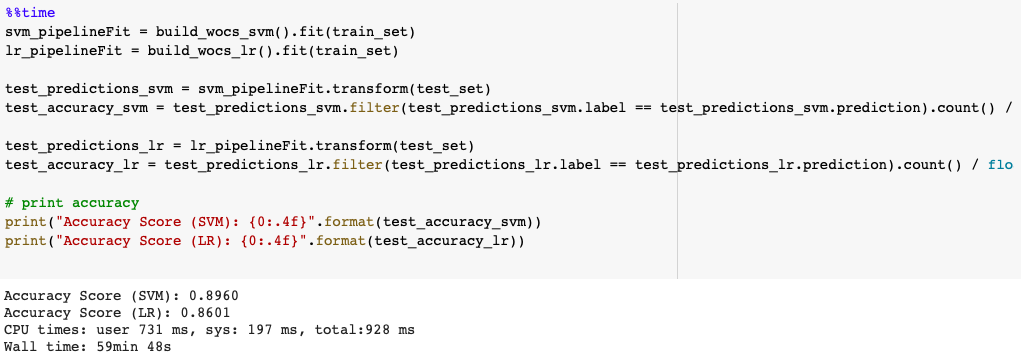

In [16]:
from IPython.display import Image
Image('Screenshot local.png')

###**2. Sentiment analysis with 2 worker nodes**

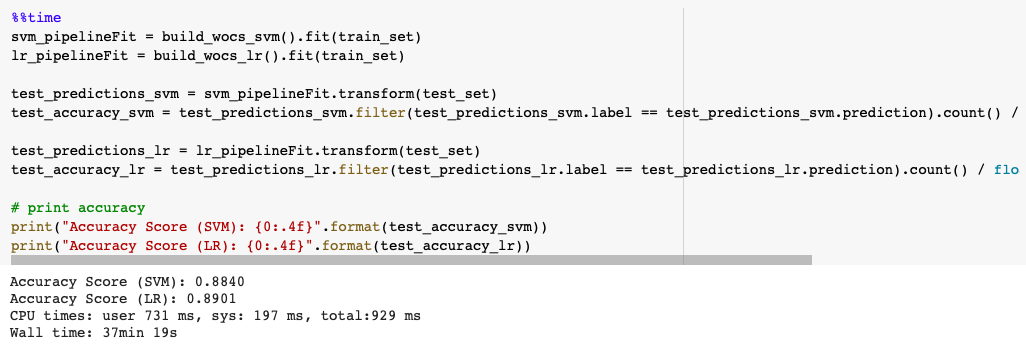

In [17]:
Image('Screenshot 2 nodes.png')

### **3. Sentiment analysis with 3 worker nodes**

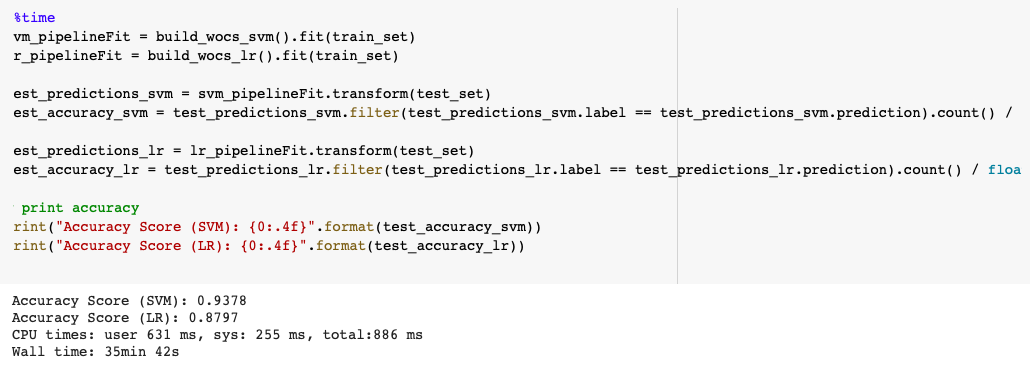

In [18]:
Image('Screenshot 3 nodes.png')


### **4. Sentiment analysis with 5 worker nodes**

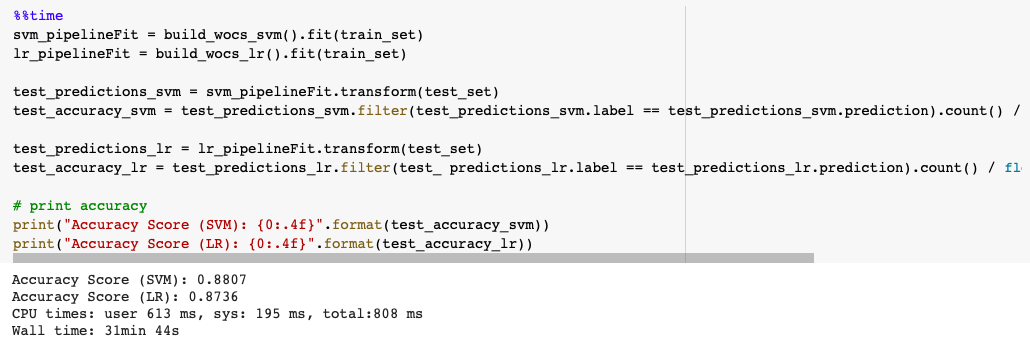

In [19]:
Image('Screenshot 5 nodes.png')

**Observation:**

* Local computer took almost 1 hour to perform sentiment analysis.
* Time taken by two worker nodes was significantly less than the local device. Time reduced by 23 minutes.
* Time taken by 3 worker nodes was less than 2 worker nodes, however the time difference was just 2 minutes.
* Time taken by 5 worker nodes was less than 3 worker nodes and the time difference was approximately 4 minutes.
* As the number of worker nodes increases, the computation time decreases.
* It is also observed that there is not much difference in accuracy of SVM and LR model when different number of cluster nodes are used. 

# **Part IV: Latent Dirichlet Allocation (LDA)**

### **1. What is LDA?**
LDA is one of the most useful topic modeling methods. Topic modeling can be defined as an unsupervised machine learning methods. It is a probabilistic generative model, which is used to find hidden pattern shown in text corpus by scanning a set of documents and then automatically cluster word groups and similar expressions that represent a set of documents and identify them as topic.[2]

In LDA, each document is associated with a distribution of topics, each topic is associated with a multinomial distribution of word and every word is drawn from a topic distribution.

### **2. What is the use of Topic Modeling?**
Topic Models are very useful for the purpose for document clustering, organizing large blocks of textual data, information retrieval from unstructured text and feature selection. For Example – New York Times are using topic models to boost their user – article recommendation engines. Various professionals are using topic models for recruitment industries where they aim to extract latent features of job descriptions and map them to right candidates. They are being used to organize large datasets of emails, customer reviews, and user social media profiles.[3]

### **3. LDA on Yelp dataset**
Here, I have performed LDA on tips dataset. I have divided the tips data into two datasets -

1. Dataset containing tips given by users to restaurants with average star rating greater than 3. These restaurants are considered as good restaurants.
2. Dataset containing tips given by users to restaurants with average star rating less than 3. These restaurants are considered as bad restaurants.

I have found out the topic distribution for the above two datasets, in order to see how the topic distribution of tips for good restaurants differs from that of bad restaurants.

#### **Getting dataframe for good restaurants**

In [0]:
review_star_three = yelp_business.select('stars','business_id').filter('stars >3')
merge_restaurant = yelp_tip.select("text","business_id").join(review_star_three,'business_id','inner')
good_restaurant = merge_restaurant.select("business_id","text").distinct()
good_restaurant.sort('business_id').show(5,False)

+----------------------+-------------------------------------------------------------------------------+
|business_id           |text                                                                           |
+----------------------+-------------------------------------------------------------------------------+
|--1UhMGODdWsrMastO9DZw|Probably my favorite Mexican place for tacos in downtown calgary               |
|--1UhMGODdWsrMastO9DZw|It is 100% my favourite Mexican restaurant in Calgary!                         |
|--1UhMGODdWsrMastO9DZw|Delicious! One of the best burritos, salsa and vegetables I've had in the city!|
|--7zmmkVg-IMGaXbuVd0SQ|Here for a wedding reception.  Very cool!                                      |
|--7zmmkVg-IMGaXbuVd0SQ|Some days a fellow can order beer by tap instead of the name.                  |
+----------------------+-------------------------------------------------------------------------------+
only showing top 5 rows



#### **Getting dataframe for bad restaurants**

In [0]:
review_star_three = yelp_business.select('stars','business_id').filter('stars < 3')
merge_restaurant = yelp_tip.select("text","business_id").join(review_star_three,'business_id','inner')
bad_restaurant = merge_restaurant.select("business_id","text").distinct()
bad_restaurant.sort('business_id').show(5,False)

+----------------------+----------------------------------------------------------------------------------+
|business_id           |text                                                                              |
+----------------------+----------------------------------------------------------------------------------+
|--Ni3oJ4VOqfOEu7Sj2Vzg|Idiots are out of wings!! No need to say anything more!!                          |
|--S62v0QgkqQaVUhFnNHrw|We're waiting up for Santa                                                        |
|--S62v0QgkqQaVUhFnNHrw|Slow service today. Confused waitress. Hard to seat family of 5                   |
|--S62v0QgkqQaVUhFnNHrw|Ghetto as fuck and horrible service. Worst Denny's ever.                          |
|--S62v0QgkqQaVUhFnNHrw|If you find your stomach growling after 2am, get yourself to Dennys. Its worth it.|
+----------------------+----------------------------------------------------------------------------------+
only showing top 5 rows



## **A. Good Restaurants**

In [0]:
# getting the rdd form of good_restaurant dataframe
good_restaurant_tips = good_restaurant.rdd

# selecting the text column
good_restaurant_tips = good_restaurant_tips.map(lambda x : x['text'])
good_restaurant_tips.take(5)

['Closed on Family Day :(',
 'Get a plain waffle with no toppings. The batter is already sweet. Be a purist!',
 'Free water bottles in your room!',
 'Just waited 1 hour to get our food. Benedict was awful and cold. Bread on turkey sandwich was stale. Skillet was pretty good. Valerie on the server staff is awesome!! Her manager... Not so much... Very rude and snapped at my mother.',
 'Big ballin with the homies!']

#### **Parse the data**

Natural language processing module (nltk) is used here to tokenize and lemmatise the words.

* Tokenisation refers to splitting of a larger body of texts into smaller units like words.

* Lemmatisation refers to grouping inflected words together in order to get their dictionary form.

In [0]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop_words = set(stopwords.words('english'))
table = str.maketrans('', '', string.punctuation)
lmtzr = WordNetLemmatizer() 

def get_tokens(line):
    tokens = word_tokenize(line)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuations from each word
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    words = [w for w in words if not w in stop_words]
    # lemmatizing the words
    words = [lmtzr.lemmatize(w) for w in words]
    return (words)

tips_rdd = good_restaurant_tips.map(lambda line: (1, get_tokens(line)))
tips_rdd.take(1)

[(1, ['closed', 'family', 'day'])]

In [0]:
doc_stop_words = tips_rdd.flatMap(lambda r: r[1]).map(lambda r: (r,1)).reduceByKey(lambda a,b: a+b)

# removing words which have occured more than 20,000 times
doc_stop_words = doc_stop_words.filter(lambda a: a[1]>20000).map(lambda r: r[0]).collect()

# throw away stop words and words that are just single letters.
tips_rdd = tips_rdd.map(lambda r: (r[0],[w for w in r[1] if not w in doc_stop_words and not len(w)==1])) 


tips_rdd.take(1)[0][1][:10]

['closed', 'family', 'day']

#### **Convert tokens into sparse vectors**

CountVectorizer and CountVectorizerModel is used to transform a set of text documents to vectors of token counts. Here, we produce vectors which are basically histograms of word counts related to every message. For the histograms of every word document, the vocabulary is kept separaty from it by the cv model.


In [0]:
from pyspark.ml.feature import CountVectorizer
from pyspark.sql.functions import monotonically_increasing_id

tips_df = spark.createDataFrame(tips_rdd, ["dummy","words"])
tips_df.cache()
tips_df.take(1)

[Row(dummy=1, words=['closed', 'family', 'day'])]

In [0]:
cv = CountVectorizer(inputCol="words", outputCol="features", minDF=2)

cv_model = cv.fit(tips_df)

tips_df_w_features = cv_model.transform(tips_df)
tips_df_w_features.cache()
tips_df_w_features.show(10)

+-----+--------------------+--------------------+
|dummy|               words|            features|
+-----+--------------------+--------------------+
|    1|[closed, family, ...|(46850,[36,81,150...|
|    1|[get, plain, waff...|(46850,[8,126,401...|
|    1|[free, water, bot...|(46850,[30,185,28...|
|    1|[waited, hour, ge...|(46850,[1,2,8,11,...|
|    1|[big, ballin, hom...|(46850,[146,6553,...|
|    1|[bouchons, carame...|(46850,[126,157,2...|
|    1|[friendlyhelpful,...|(46850,[0,17,21,3...|
|    1|[great, grave, sp...|(46850,[0,1,2,43,...|
|    1| [make, reservation]|(46850,[34,256],[...|
|    1|[avocado, sandwic...|(46850,[13,44,76,...|
+-----+--------------------+--------------------+
only showing top 10 rows



#### **Latent Dirichlet Allocation**
Now, the dataset is analysed using LDA. Here, the number of topics 'k' is equal to 15.

In [0]:
from pyspark.ml.clustering import LDA

lda = LDA(k=15, maxIter=20)

lda_model = lda.fit(tips_df_w_features)

In [0]:
# Describe topics
topics = lda_model.describeTopics(20)

print("The topics are:")
#topics.show(truncate=False)

# Shows the results
import numpy as np
topic_i = topics.select("termIndices").rdd.map(lambda r: r[0]).collect()
for i in topic_i:
    print(np.array(cv_model.vocabulary)[i])

The topics are:
['awesome' 'nice' 'place' 'beautiful' 'patio' 'love' 'cute' 'store' 'home'
 'outside' 'view' 'seating' 'coffee' 'inside' 'hidden' 'area' 'like' 'gem'
 'fantastic' 'loved']
['see' 'pedi' 'mmmm' 'grand' 'shot' 'opening' 'massage' 'mani' 'deep'
 'gras' 'time' 'crap' 'foie' 'mind' 'holy' 'trying' 'tissue' 'gel' 'aloha'
 'blow']
['great' 'food' 'service' 'good' 'place' 'friendly' 'staff' 'love' 'price'
 'nice' 'excellent' 'amazing' 'always' 'awesome' 'back' 'atmosphere'
 'delicious' 'really' 'customer' 'lunch']
['best' 'ever' 'pizza' 'town' 'place' 'vega' 'hand' 'one' 'rib' 'get'
 'worst' 'love' 'go' 'style' 'crab' 'sushi' 'around' 'far' 'time' 'valley']
['nt' 'place' 'get' 'time' 'go' 'love' 'make' 'come' 'wait' 'like' 'great'
 'new' 'back' 'one' 'ca' 'order' 'take' 'first' 'check' 'sure']
['hour' 'happy' 'pm' 'everyday' 'daily' 'http' 'menu' 'special' 'good'
 'hh' 'winner' 'woo' 'mon' 'drink' 'mf' 'boo' 'great' 'reverse' 'close'
 'fri']
['parking' 'lot' 'yes' 'street' 'par

## **B. Bad Restaurant**

In [0]:
# getting the rdd form of good_restaurant dataframe
bad_restaurants_rdd = bad_restaurant.rdd
bad_restaurant_tips = bad_restaurants_rdd.map(lambda x : x['text'])
bad_restaurant_tips.take(5)

['Gaterade sales!!!!',
 'Wings and taterskins!',
 "Slow service today.  Not very busy.  They do have a kids table set up with activities that's nice. V",
 'Extra charge for a side of hot salsa?!? No never mind then.  This bi*ch fucked with me big time. Grrrr!!!!!',
 'I admit, I may have the patience of a rattlesnake but waiting for 30 min to get 9 waters, coffee & someone to take breakfast orders in a dead place could test even the likes of Mother Teresa. Do yourself & your sanity a favor & DON\'T ever eat @Denny\'s in Champaign, IL. FYI: NOT my idea to eat here but confirmed why I just say NO to Denny\'s! Slowest service EVER: 2 hrs of pure dining torture for nasty coffee & inedible eggs! If Denny\'s is "America\'s Diner," we have a national crisis on our hands!']

#### **Parse the data**

In [0]:
tips_rdd2 = bad_restaurant_tips.map(lambda line: (1, get_tokens(line)))
tips_rdd2.take(1)

[(1, ['gaterade', 'sale'])]

In [0]:
doc_stop_words2 = tips_rdd2.flatMap(lambda r: r[1]).map(lambda r: (r,1)).reduceByKey(lambda a,b: a+b)

# removing words which have occured more than 20,000 times
doc_stop_words2 = doc_stop_words2.filter(lambda a: a[1]>20000).map(lambda r: r[0]).collect()

# throw away stop words and words that are just single letters.
tips_rdd2 = tips_rdd2.map(lambda r: (r[0],[w for w in r[1] if not w in doc_stop_words2 and not len(w)==1])) 
tips_rdd2.take(1)[0][1][:10]



['gaterade', 'sale']

#### **Convert tokens into sparse vectors**

In [0]:
tips_df2 = spark.createDataFrame(tips_rdd2, ["dummy","words"])
tips_df2.cache()
tips_df2.take(1)

[Row(dummy=1, words=['gaterade', 'sale'])]

In [0]:
cv2 = CountVectorizer(inputCol="words", outputCol="features", minDF=2)

cv_model2 = cv2.fit(tips_df)

tips_df_w_features2 = cv_model2.transform(tips_df2)
tips_df_w_features2.cache()
tips_df_w_features2.show(10)

+-----+--------------------+--------------------+
|dummy|               words|            features|
+-----+--------------------+--------------------+
|    1|    [gaterade, sale]| (46801,[389],[1.0])|
|    1|  [wing, taterskins]| (46801,[107],[1.0])|
|    1|[slow, service, t...|(46801,[58,85,87,...|
|    1|[extra, charge, s...|(46801,[33,40,92,...|
|    1|[admit, may, pati...|(46801,[1,15,20,3...|
|    1|[carpool, make, e...|(46801,[1892,9751...|
|    1|[hate, going, place]|(46801,[65,977],[...|
|    1|[excellent, servi...|(46801,[131,1220,...|
|    1|[ask, room, newer...|(46801,[18,136,22...|
|    1|[excellent, custo...|(46801,[2,44,72,8...|
+-----+--------------------+--------------------+
only showing top 10 rows



#### **Latent Dirichlet Allocation**


In [0]:
lda2 = LDA(k=15, maxIter=20)

lda_model2 = lda2.fit(tips_df_w_features2)

In [0]:
# Describe topics
topics2 = lda_model2.describeTopics(20)

print("The topics are:")
#topics.show(truncate=False)

# Shows the results
import numpy as np
topic_i = topics2.select("termIndices").rdd.map(lambda r: r[0]).collect()
for i in topic_i:
    print(np.array(cv_model2.vocabulary)[i])

The topics are:
['worst' 'suck' 'minute' 'table' 'could' 'night' 'starbucks' 'even'
 'discount' 'got' 'cool' 'late' 'people' 'pay' 'thank' 'water' 'reward'
 'slow' 'need' 'every']
['doctor' 'help' 'wonderful' 'thanks' 'birthday' 'next' 'year' 'got' 'way'
 'value' 'buffet' 'even' 'slow' 'went' 'right' 'better' 'nom' 'flavor'
 'call' 'know']
['terrible' 'night' 'experience' 'yum' 'nail' 'egg' 'old' 'bacon' 'cheese'
 'soup' 'customer' 'gross' 'friend' 'fried' 'bring' 'sunday' 'rude'
 'never' 'town' 'biscuit']
['wifi' 'work' 'lol' 'cheap' 'want' 'piece' 'opening' 'kid' 'never' 'shit'
 'area' 'school' 'shopping' 'people' 'shake' 'table' 'hot' 'black'
 'elsewhere' 'car']
['store' 'customer' 'review' 'wing' 'helpful' 'today' 'door' 'kid'
 'coming' 'shop' 'people' 'slow' 'need' 'close' 'bad' 'tip' 'location'
 'star' 'next' 'open']
['closed' 'horrible' 'sandwich' 'never' 'location' 'open' 'rude' 'avoid'
 'eat' 'salad' 'customer' 'gas' 'made' 'ca' 'tasty' 'getting' 'pharmacy'
 'cost' 'going' 'wo

**Observation:**

* Topics returned for good restaurants are generally positive topics. 
* Topics returned for bad restaurants are generally negative topics. These topics are mostly representing the service, food, waiting time and the place
* Topics are indicative of the sentiment of the rating. 


## **C. Wordcloud of tips corresponding to good and bad rating** 

In [0]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

# function defined to get the word cloud
def show_wordcloud(data,x, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,collocations=False).generate(" ".join(x))

    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=10)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

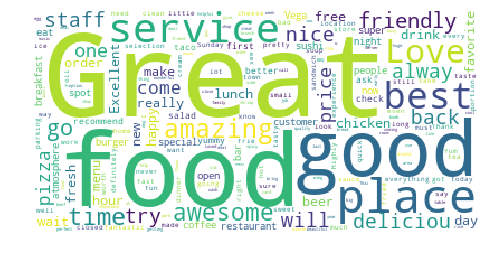

In [0]:
good_rating_temp = good_restaurant.select('text').collect()

# creating a list of texts
good_rating_list = []
for i in range(len(good_rating_temp)):
    good_rating_list.append(str(good_rating_temp[i].text))

show_wordcloud(good_rating_list,good_rating_list)

**Observation:**

From the wordcloud, it can be observed that the restaurants which have star ratings greater than 3 have gotten lots of praises. We can see that positive words like 'great', 'good', 'best', 'friendly', 'nice', 'awesome', 'delicious' etc. have been used a lot in the tips given by the users. It can also be seen that a lot of tips have been about the service and food of the restaurants.

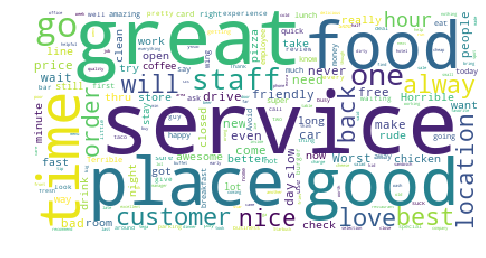

In [0]:
poor_rating_temp = bad_restaurant.select('text').collect()

# creating a list of texts
poor_rating_list = []
for i in range(len(poor_rating_temp)):
    poor_rating_list.append(str(poor_rating_temp[i].text))
    
show_wordcloud(poor_rating_list,poor_rating_list)

**Observation:**

The word cloud for the restaurants which have star ratings less than 3 shows that the customers have spoken mainly about their service, food and time. The tips have both positive and negative words. Positive words like 'great', 'good' and 'nice' have been used a lot in the tips. However, negative words like 'worst', 'horrible', 'bad' etc. have also been used substantially. These words could have been used to describe the service, food or the place.
It can also been seen that words like 'time', 'wait', 'hour', 'minutes', 'line' have been used a lot. This suggests that these resaurants probably have poor service with respect to time and thus, have a long waiting time for their customers. 

# **Conclusion**
The aim of this project was to explore Yelp data using Spark SQL and perform sentiment analysis and Latent Dirichlet Allocation on the reviews and tips given by the users respectively. This project also aimed at understanding how the computation time varies with different number of worker nodes in a cluster. 

The exploration of Yelp data depicts that Yelp includes many categories of businesses like restaurants, food, shopping, beauty & spa, health & medical, home services etc. There are 63,944 restaurants, thus, making it the most popular business. Las Vegas has maximum number of businesses, however, Toronto has highest number of restaurants. It is also observed that more than 60% of the ratings given to the restaurants is greater than 3 stars. About 31% of the restaurants given in the dataset are closed now and approximately 75% of these restaurants had star rating below 4. From the analysis of users dataset, it is inferred that top 10 users are mostly the elite members and have a huge number of fans. Also, on an average the star rating for these top user is 3.6.

Sentiment analysis performed on reviews given by the yelp users using Support Vactor Machine and Logistic Regression  gave an accuracy score of 0.8991 and 0.8981 and an F1 score of 0.8942 and 0.8999 for SVM and LR respectively. This suggests that both the models have done reasonaby well in classifying the sentiments of the users as positive or negative. 

The performance comparison of different number of worker nodes depicts that as the number of worker nodes increases the computation time reduces. It can also be seen that there is a very significant time difference of 30 minutes between the execution of code on local computer and that of on 5 worker nodes cluster.

The Latent Dirichlet Allocation performed on the tips given to the restaurants with greater than and less than 3 star ratings shows different topic distributions for the good and bad resturants, and these topics are indicative of sentiments of the users. 

It can be concluded that distributed computing is better suited for big data analytics than traditional sigle node computing. The tools and technologies are making it increasingly simple to distriute workloads. The slight increase in expenses is well worth the time saved and even these costs are rapidly coming down with the drop in cloud computing rates.


# **References**
[1]  Michael Luca, (2016). "Reviews, Reputation, and Revenue: The Case of Yelp.com" 



[2]  Pascual Federico, (2019). "Introduction to Topic Modeling". Retrieved from https://monkeylearn.com/blog/introduction-to-topic-modeling/

[3]Kulshrestha Ria, (2019). "A Beginner’s Guide to Latent Dirichlet Allocation(LDA)". Retrieved from https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/
[4] Hajas, Peter & Gutierrez, Louis & Krishnamoorthy, Mukkai. (2014). Analysis of Yelp Reviews. 

[5] David M. Blei, Andrew Y. Ng & Michael I. Jordan, (2003). "Latent Dirichlet Allocation"

[6] Fang, X., Zhan, J. Sentiment analysis using product review data. Journal of Big Data 2, 5 (2015). 

[7] Sultana, Najma & Kumar, Pintu & Patra, Monika & Chandra, Sourabh & Alam, Sk. (2019). SENTIMENT ANALYSIS FOR PRODUCT REVIEW. International Journal of Soft Computing. 09. 7. 10.21917/ijsc.2019.0266. 

[8] Tong, Zhou & Zhang, Haiyi. (2016). A Text Mining Research Based on LDA Topic Modelling. Computer Science & Information Technology. 6. 201-210. 10.5121/csit.2016.60616. 